# Report Title

---

_**Brief Report Objective**_

---


## Table of Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data Cleaning](#Data-Cleaning)
1. [Numerical EDA](#Numerical-EDA)
1. [Graphical EDA](#Graphical-EDA)
1. [Train Test Split](#Train-Test-Split)
1. [Feature Engineering](#Feature-Engineering)
2. [Data Preprocessing](#Data-Preprocessing)
3. [Baseline Model](#Baseline-Model)
4. [Model Training](#Model-Training)
5. [Model Evaluation (K Fold Cross Validation)](#Model-Evaluation-K-Fold-Cross-Validation)
   1. [Baseline Model Comparison](#Baseline-Model-Comparison)
6. [Model Selection](#Model-Selection)
7. [Model Tuning](#Model-Tuning)
8. [Final Model Evaluation](#Final-Model-Evaluation)
9. [Bringing it All Together in a Pipeline](#Bringing-it-All-Together-in-a-Pipeline)
10. [Conclusion](#Conclusion)
11. [Appendix](#Appendix)

---


### Introduction

**Objective**: Extended Report Objective (What type of Machine Learning task is this ? What are you looking to find out ?)

Our dataset we are analyzing contains information about **{{ data_description }}**. It has **{{ data_columns }}** columns and **{{ data_rows }}** rows.

The columns of the dataset are:
1. `predictor_column_1` - *description*
1. `predictor_column_2` - *description*
1. `predictor_column_3` - *description*
1. `predictor_column_4` - *description*
1. `target_column` **(target)** - *description*

We are trying to predict `target_column` using the other variables as our predictors. 

First, we will perform *exploratory data analysis* (EDA) to better understand the relationships of our predictors to `target_column`. Next, we will *create new features from our existing data* (feature engineering) to explore new relationships with `target_column` with the hope of increase our model's predcitive power. We will then transform our data into a format our models understand and evaluate their performance on our *test data*, selecting the most accurate model at the end and fine tuning it. This allows us to estimate our model will do in *production* (ie, how well it will predict future observations). Finally, we will tie together all of the steps from into a *pipeline* so that our code is as compact and understandable as possible.

---

### Setup

Import all the Python libraries we will need

---

In [3]:
# Add imports here
from itertools import combinations
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy.stats
import phik

In [4]:
# Read in Data from Database
# conn = os.environ["DB_URL"]
# query = ""
# data = pd.read_sql(query, con=conn)
# Read in Data from CSV
# data = pd.read_csv("path_to_csv.csv")
data = pd.read_csv("/Users/nathanjones/Python-Scripts/VSCode/datacamp/certification/datacamp_ds_associate_cert_electric_moped_reviews_data.csv")

# Preview Dataframe
data.head()

# If problems are identified in preview fix them here (wrong column headers, wrong delimiter, etc.)

,owned,make_model,review_month,web_browser,reviewer_age,primary_use,value_for_money,overall_rating
0,1,Nielah-Eyden,Oct,Chrome,23,Commuting,5/10,18.62
1,0,Nielah-Keetra,Jun,NaN,24,Commuting,4/10,15.55
2,0,Lunna-Keetra,23-Oct,Chrome,28,Commuting,5/10,12.76
3,1,Hoang-Keetra,07-Nov,IE,41,Leisure,5/10,17.07
4,1,Lunna-Keetra,16-Sep,Chrome,33,Leisure,5/10,12.29


### Data Cleaning

---

In [5]:
# Drop duplicates
duplicate_count = len(data) - len(data.drop_duplicates())
print(f"{duplicate_count} duplicate rows found\nTo examine them run: data[data.duplicated(keep=False)]\nTo drop them run: data.drop_duplicates(inplace=True)")
if duplicate_count > 0:
    data.drop_duplicates(inplace=True)
    print(f"Dropped {duplicate_count} duplicate rows")

0 duplicate rows found
To examine them run: data[data.duplicated(keep=False)]
To drop them run: data.drop_duplicates(inplace=True)


In [6]:
# Shape of data, dtypes, NULL Counts, duplicate rows, dtype counts, distributions of numeric columns, # of unqiue values for string / categorical types

# Shape of data
print(f"Dataframe has {data.shape[0]} rows and {data.shape[1]} columns")
print("\n")

# Data Types and Missing Values
print(f"Data Types, Missing Values Per Column, and Unique Values Per Column:\n")
df_overview = pd.DataFrame({
    "Column Name": data.columns,
    "Data Type": data.dtypes,
    "# Missing Values": data.isnull().sum(),
    "% Missing Values": data.isnull().mean() * 100,
    "Unique Values": data.nunique()
}).sort_values(by=["Data Type", "% Missing Values"]).reset_index(drop=True)
display(df_overview)
print("\n")

# Duplicate rows
data[data.duplicated()]

# Data Types Counts
print(f"Data Types Counts:\n")
display(data.dtypes.value_counts())

Dataframe has 1500 rows and 8 columns


Data Types, Missing Values Per Column, and Unique Values Per Column:



,Column Name,Data Type,# Missing Values,% Missing Values,Unique Values
0,owned,int64,0,0.0,2
1,overall_rating,float64,0,0.0,583
2,make_model,object,0,0.0,6
3,review_month,object,0,0.0,332
4,reviewer_age,object,0,0.0,36
5,primary_use,object,0,0.0,2
6,value_for_money,object,0,0.0,10
7,web_browser,object,150,10.0,6




Data Types Counts:



object     6
int64      1
float64    1
dtype: int64

**{{ make observation on what needs to be cleaned up or addressed now vs later }}**

**Changing of dtypes, handling of nulls, high cardinality categorical variables, etc.**

* Are some columns the wrong datatype ?
* Are there columns with a lot of NULL values ?
* Are there categorical columns with > 4 categories ?
* Could some columns be better represented via binning ? (Converting a `numeric` variable into `catgeorical`)

In [7]:
# Clean data / address issue to fix now

### Numerical EDA

---

In [8]:
# Shape of data, dtypes, NULL Counts, dtype counts, distributions of numeric columns, # of unqiue values for string / categorical types, possible outliers etc.
## You can get a very good and quick EDA using pandas-profiling

# Create pandas_profiling EDA Report
profile = ProfileReport(data, title="Pandas Profiling Report")
# Display pandas_profiling EDA Report
profile.to_notebook_iframe()

# Summary Statistics
print(f"Numeric Variables Summary Statistics\n")
display(data.describe())
print("\n")

# Identify Potential Outliers using the IQR Method
quant1 = []
quant3 = []
int_quartile_range = []
outlier_counts = []
for col_name in data.select_dtypes("number").columns:
    q1 = data[col_name].quantile(0.25)
    q3 = data[col_name].quantile(0.75)
    iqr = q3 - q1
    outlier_count = len(data[col_name][(data[col_name] < (q1 - 1.5 * iqr)) | (data[col_name] > (q3 + 1.5 * iqr))])
    outlier_counts.append(outlier_count)
    quant1.append(q1)
    quant3.append(q3)
    int_quartile_range.append(iqr)
outlier_df = pd.DataFrame({
    "column": data.select_dtypes("number").columns,
    "q1": quant1,
    "q3": quant3,
    "iqr": int_quartile_range,
    "outlier_count": outlier_counts
}).sort_values(by="outlier_count", ascending=False).reset_index(drop=True)
print(f"\nNumber of potential outliers per column (IQR method)\n")
print(f"To examine outliers run: data[((data[col_name] < (q1 - 1.5 * iqr)) | (data[col_name] > (q3 + 1.5 * iqr)))]")
display(outlier_df)
    

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Numeric Variables Summary Statistics



,owned,overall_rating
count,1500.000000,1500.000000
mean,0.593333,17.138907
std,0.491375,2.445566
min,0.000000,11.690000
25%,0.000000,15.320000
50%,1.000000,18.240000
75%,1.000000,18.840000
max,1.000000,22.760000





Number of potential outliers per column (IQR method)

To examine outliers run: data[((data[col_name] < (q1 - 1.5 * iqr)) | (data[col_name] > (q3 + 1.5 * iqr)))]


,column,q1,q3,iqr,outlier_count
0,owned,0.00,1.00,1.00,0
1,overall_rating,15.32,18.84,3.52,0


**{{ make_observations_here }}**

**Potential outliers, handling of nulls, high cardinality categorical variables, etc.**

* Did you forget to change some columns to the correct types ?
* Are there a lot of outliers for any of the columns ?
* Do any of the quantiles stick out right away ? Be sure to analyze these when doing Graphical EDA
* Check out some of the outliers and see if they could be legit outliers or not. Graphical EDA can help visualize this

### Graphical EDA

---

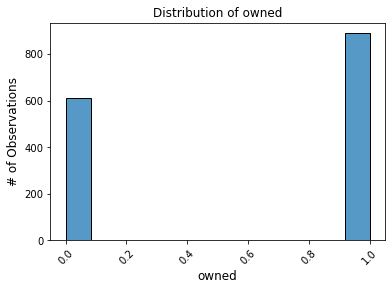

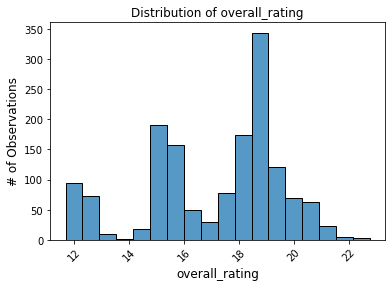

In [9]:
# Distributions - Histogram, KDE, ECDF
# Categorical - Count plots, boxplots, violinplot
### Mixutre of single variable plots, 2+ variable plots for Distributions and Categorical
# Relational - Pair plots / scatter plots, line plots, boxplots. Try 2 variable combinations, and add a hue for 3rd variable to see interaction relationship

# Set axis label sizes to slightly larger than default
plt.rcParams["axes.labelsize"] = 12

# Single Variable 

# Distributions
for col_name in data.select_dtypes(include="number").columns:
    sns.histplot(data=data, x=col_name)
    plt.title(f"Distribution of {col_name}")
    plt.xticks(rotation=45)
    plt.ylabel("# of Observations")
    plt.show()

**{{ make_observations_here }}**

**Distribution Types, Outliers, General Aknowledgements**

* Do you notice any common distributions (Normal, Bimodal, Exponential, etc.) ?
  * What does impact does this have on Data Preprocessing (Scaling, Centering, etc.) ?
* Are there a lot of outliers for any of the columns ?
* Do any variables lend theaccuracylves to binning / are there "numeric" variables that actually represent discrete categories ?
  * Be aware of impacts on model. If you use a linear model and predictor has a linear relationship with target, then binning isn't recommended.
* Did some of the distributions lead you to a follow up question (check outliers, etc.) ? If so explore them here

In [10]:
# Follow up analysis and plots

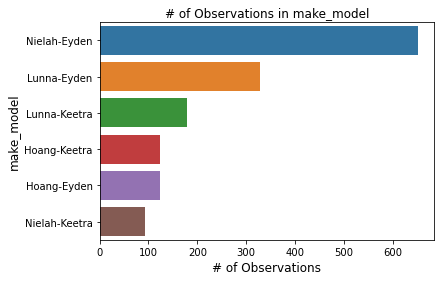

🚨 review_month column had 20 or more unique values, so distribution skipped. Consider binning this variable 🚨


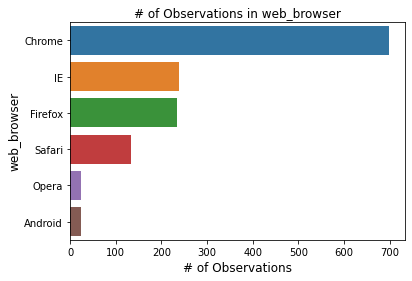

🚨 reviewer_age column had 20 or more unique values, so distribution skipped. Consider binning this variable 🚨


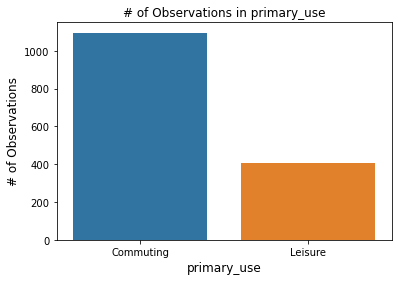

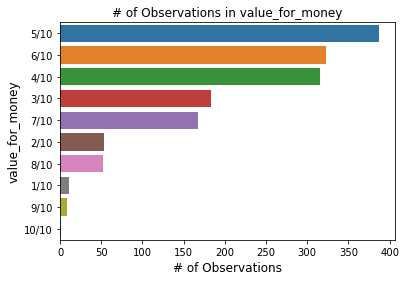

In [11]:
# Single Variable

# Categorical
for col_name in data.select_dtypes(exclude="number").columns:
    nunique = data[col_name].nunique()
    desc_order = data[col_name].value_counts().index
    if nunique > 5 and nunique < 20:
        sns.countplot(data=data, y=col_name, order=desc_order)
        plt.title(f"# of Observations in {col_name}")
        plt.xlabel("# of Observations")
        plt.ylabel(col_name)
        plt.show()
    elif nunique <= 5:
        sns.countplot(data=data, x=col_name, order=desc_order)
        plt.title(f"# of Observations in {col_name}")
        plt.ylabel("# of Observations")
        plt.xlabel(col_name)
        plt.show()
    else:
        print(f"🚨 {col_name} column had 20 or more unique values, so distribution skipped. Consider binning this variable 🚨")

**{{ make_observations_here }}**

**Distribution Types, Outliers, General Aknowledgements**

* Are there very few observations for any of the classes of a variable ?
  * What does impact does this have on Data Preprocessing (Train Test Split / classes in Train but not Test) ?

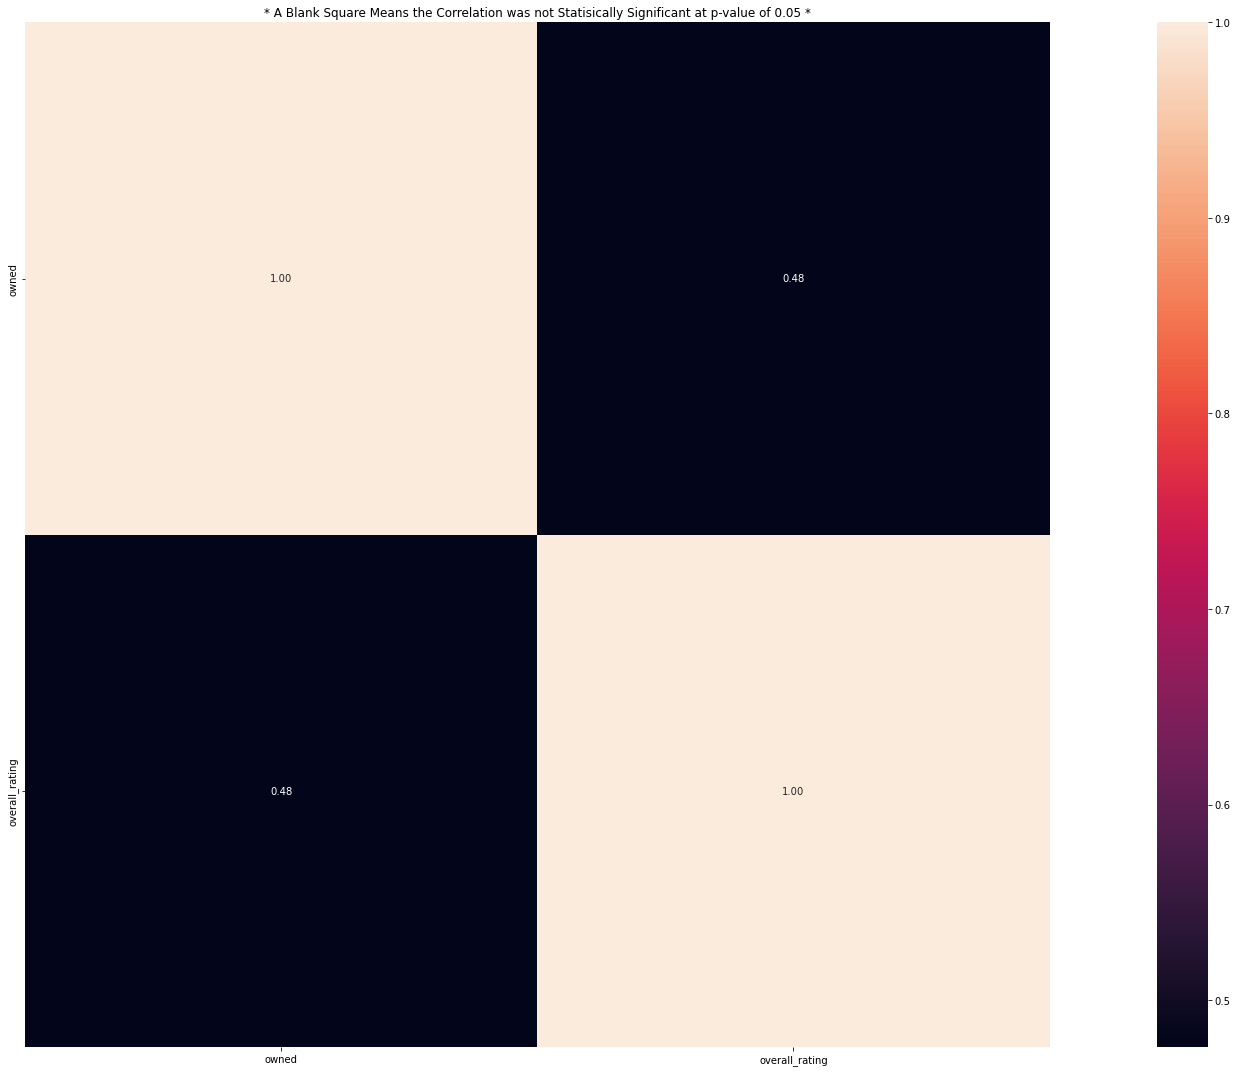

In [12]:
# Pearson's r Correlation Heatmap
# Correlation Matrix

# Code to "mask" correlations that are not statistically significant from heatmap
def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = scipy.stats.pearsonr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix

# p_values = corr_sig(data.select_dtypes('number'))
# mask = np.invert(np.tril(p_values<0.05))

# Set up the matplotlib figure
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(30, 15))

# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(data.corr(method="pearson"),
                    #    mask=mask,
                       annot=True,
                       fmt='.2f',
                       square=True)
g.set(title="* A Blank Square Means the Correlation was not Statisically Significant at p-value of 0.05 *")
f.set_tight_layout(True)

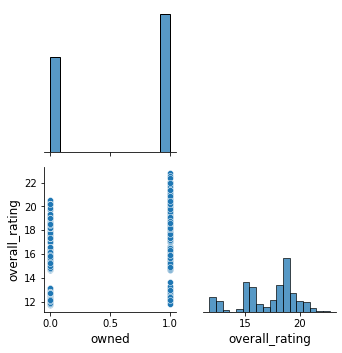

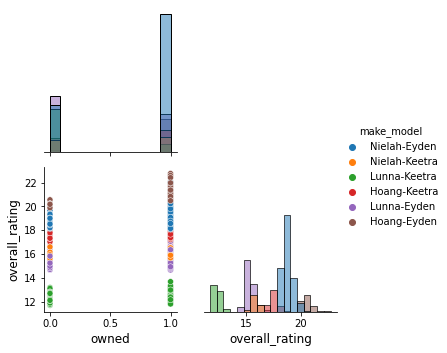

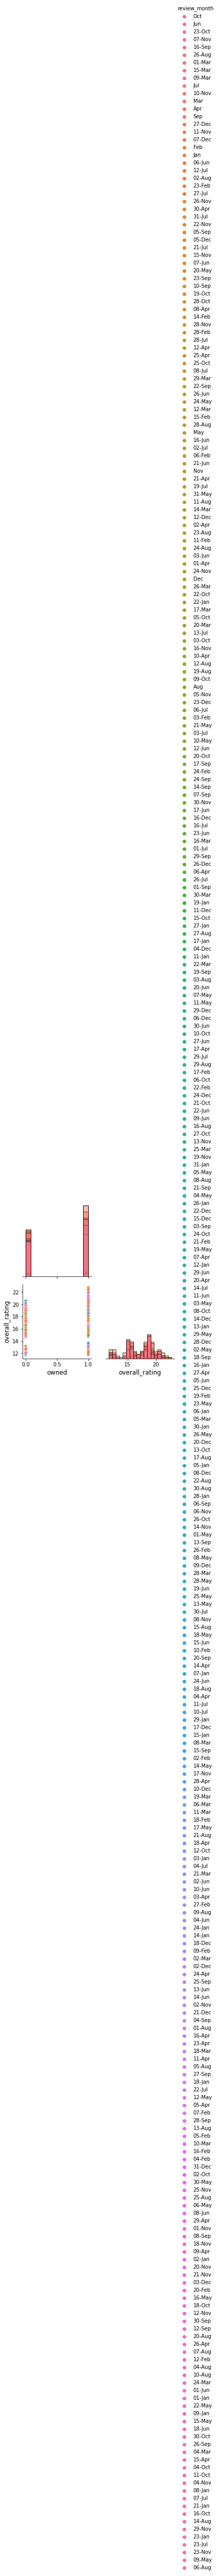

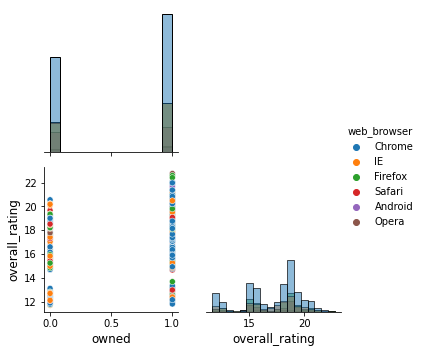

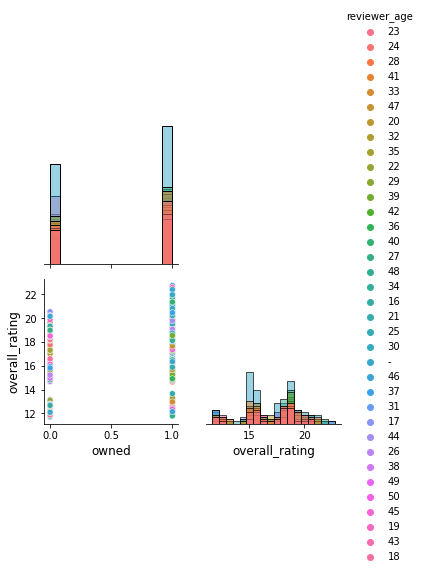

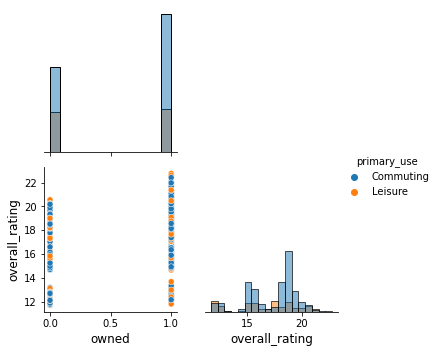

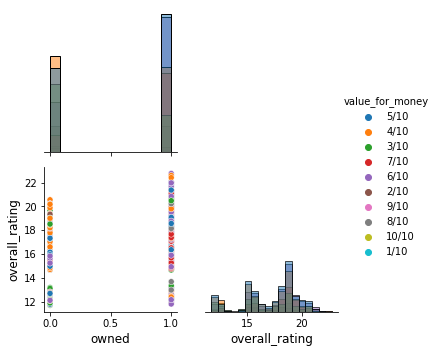

In [13]:
# Multiple Variables

# Relational

# No hue
g = sns.PairGrid(data, corner=True)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
plt.show()

# With hue for each categorical variable
for col_name in data.select_dtypes(exclude="number").columns:
    g = sns.PairGrid(data, corner=True, hue=col_name)
    g.map_diag(sns.histplot)
    g.map_offdiag(sns.scatterplot)
    g.add_legend()
    plt.show()

**{{ make_observations_here }}**

**Notable relationships to target, correlated predictors, predictor interactions relationships to target, etc.**

* Do any of variables have a noticable relationship to the target (Linear or Non-Linear) ?
  * What does impact does this have on type of models you will test ?
* Are any of the predictors highly correlated (linear correlation) with each other ?
  * [Multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity) may need to be addressed for Linear Models for interpretability, but does not impact predictive accuracy.
* Do you notice any interesting interactions (X-axis + color) on the target ?
  * If yes, then consider adding interaction terms during feature engineering.

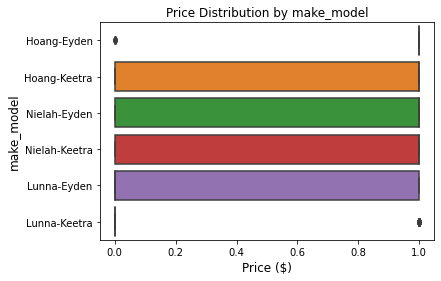

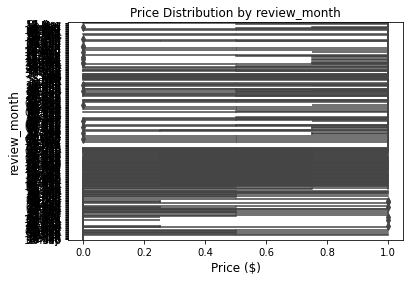

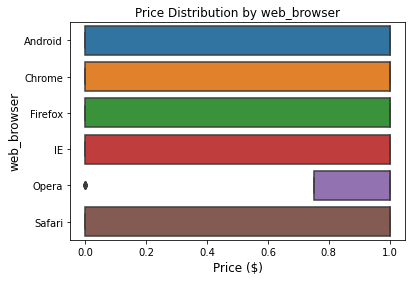

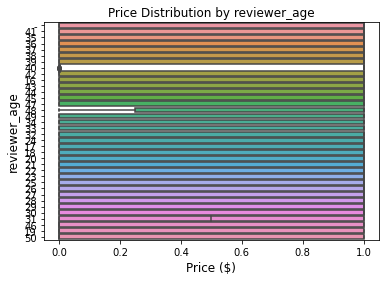

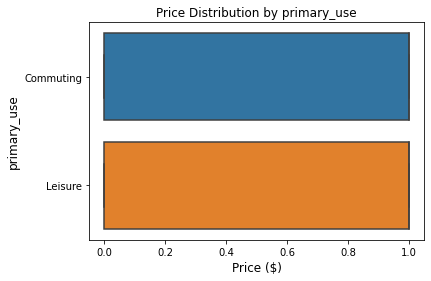

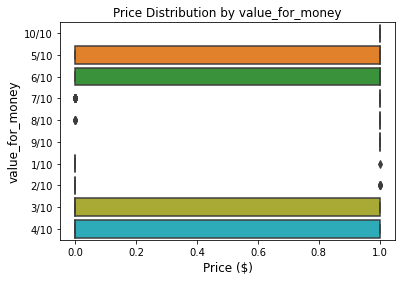

In [14]:
# Multiple Variables

# 🚨 Replace with target column name 🚨
target = "owned"
data["owned"] = data["owned"].astype(int)
for col_name in data.select_dtypes(exclude="number").columns:
    # Medians in descending order
    desc_order = data.groupby(by=[col_name])[target].median().sort_values(ascending=False).index
    g = sns.boxplot(data=data, y=col_name, x=target, order=desc_order)
    g.set(xlabel="Price ($)", ylabel=col_name)
    g.set_title(f"Price Distribution by {col_name}")
    plt.show()

# Target vs Category for each Category
# g = sns.boxplot(data=data, y="fuelType", x=target)
# g.set(xlabel="Price ($)", ylabel="Fuel Type")
# g.set_title("Price Distribution by Fuel Type")
# plt.show()

**{{ make_observations_here }}**

**Interesting Interactions**

* Can you identify any relationships between categorical predictor classes and the target ?
  * If, so then try to dig deeper on this relationship when doing *3 variable interaction*
* Explore whether the relationships seen here are independent of other predictors or not
  * Create some hypothesis and test them with more plots

In [15]:
L = data.select_dtypes(exclude="number").columns
# All unqiue 2 way combinations
unique_2_way_combos = [comb for comb in combinations(L, 2)]
for i, j in unique_2_way_combos:
    g = sns.catplot(data=data, y=i, x=target, col=j, kind="box")
    g.set_axis_labels("Price ($)", i)
    g.set_titles("{col_var} = {col_name}")
    g.fig.subplots_adjust(top=0.8)
    g.fig.suptitle(f"Price Distribution by {i} and {j}")
    plt.show()

ValueError: Image size of 119520x360 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 119520x360 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 119520x360 with 332 Axes>

**{{ make_observations_here }}**

**Interesting Interactions**

* Can you identify any relationships between categorical predictor classes and the target ?
* Did adding a 3rd variable expose a new trend that you didn't see as clearly with 2 variables ?

interval columns not set, guessing: ['owned', 'overall_rating']


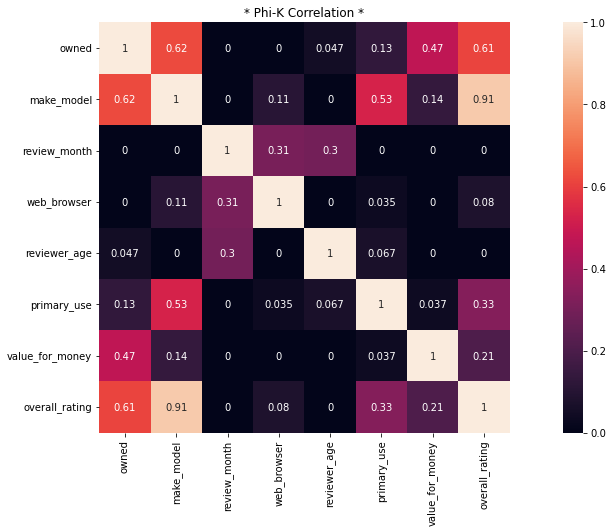

In [17]:
# Phi-k Correlations (Categorical and Numeric combined)
f, ax = plt.subplots(figsize=(15, 7.5))
g = sns.heatmap(data=data.phik_matrix(), annot=True, square=True)
g.set(title="* Phi-K Correlation *")
f.set_tight_layout(True)

### Train Test Split

In [18]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=[target])
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

### Feature Engineering

---

In [19]:
# Create new features based on hypothesis you want to test after EDA
# interaction terms, n-grams and tokenization, 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_extraction.text import CountVectorizer

### Data Preprocessing

---

In [20]:
# Apply preprocessing transformations using ColumnTransformer to handle numerical and categorical features separately.
# Scale numeric features, One Hot Encode categorcial features, imputation for both
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Categorical preprocessing
categorical_transformer = Pipeline(steps=[
    ('onehot_encoder', OneHotEncoder(handle_unknown="ignore")),
    ('categorical_imputer', SimpleImputer(strategy="most_frequent"))
])

# Numeric preprocessing
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('numeric_imputer', SimpleImputer(strategy="mean"))
])

# Combine categorical and numerical preprocessing into single preprocessor
numeric_features = X_train.select_dtypes(include="number").columns.values
categorical_features = X_train.select_dtypes(exclude="number").columns.values
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", numeric_transformer, numeric_features),
    ]
)
# Apply preprocessing to the Train and Test sets
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.fit_transform(X_test)

### Baseline Model

---

In [21]:
# Either use a simple model like Linear Regression / KNN or just the average value. You should be able to do better than this
from sklearn.metrics import accuracy_score, confusion_matrix

mode_y = data[target].mode()
print(f"Mode value of {target}")
print(f"Mode value of the target = {mode_y.iloc[0]:,.2f}")
y_pred = [mode_y] * len(y_test)
print(f"Baseline Model Test Accuracy (using mode as the predicted value) = {accuracy_score(y_test, y_pred):,.2f}")

Mode value of owned
Mode value of the target = 1.00
Baseline Model Test Accuracy (using mode as the predicted value) = 0.60


The baseline model simply used the average value as its prediction for each time. We need our model to be at least better than this simple baseline model's Accuracy.

**Add another baseline Accuracy here with a simple model**

### Model Training

---

In [22]:
# Test out different models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Model Evaluation (K Fold Cross Validation)

---

### Model Selection

---

### Model Tuning

---

### Final Model Evaluation

---

### Bringing it All Together in a Pipeline

---

In [23]:
# import modules
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier

In [25]:
# Train Test Split
X = data.drop(columns=target)
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)


# Define different Pipelines for Numeric vs. Categorical
numeric_transformer = Pipeline(
    steps=[
        ("numeric_imputer", SimpleImputer(strategy="mean")), 
        ("scaler", StandardScaler())
        ]
)

categorical_transformer = Pipeline(
    steps=[
        ("categorical_imputer", SimpleImputer(strategy="most_frequent")), 
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]
)

numeric_features = X_train.select_dtypes(include="number").columns.values
categorical_features = X_train.select_dtypes(exclude="number").columns.values

# Combine into single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", numeric_transformer, numeric_features),
    ]
)


# Define a single Pipeline with all of the steps
models = [LogisticRegression(), KNeighborsClassifier(), RandomForestClassifier(), XGBClassifier()]
cv_Accuracys = []
for model in models:
    steps = [
        ('preprocessor', preprocessor),
        ('interactions', PolynomialFeatures()),
        # ('dim_red', SelectKBest(score_func=f_classif, k=300)),
        # Try different models and select the one with the best cross_val_score
        ('regressor', model)
    ]
    pipeline = Pipeline(steps)
    cv_Accuracy = cross_val_score(pipeline, X_train, y_train, cv=4, scoring='accuracy').mean()
    print(f"{model} Cross Validation Accuracy\n{cv_Accuracy:,.2f}")
    cv_Accuracys.append(cv_Accuracy)

/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

LogisticRegression() Cross Validation Accuracy
0.70
KNeighborsClassifier() Cross Validation Accuracy
0.67
RandomForestClassifier() Cross Validation Accuracy
0.73
[10:42:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:42:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:42:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:42:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=Non

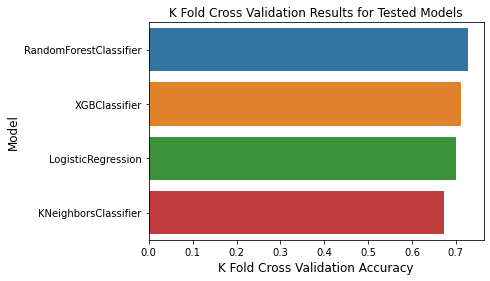

,model,cross_validation_accuracy
2,RandomForestClassifier,0.727086
3,XGBClassifier,0.711094
0,LogisticRegression,0.699556
1,KNeighborsClassifier,0.673743


Maximum cross validation Accuracy (0.73) acheived with RandomForestClassifier model


In [26]:
cv_results = pd.DataFrame({
    "model": [str(model).split("(")[0] for model in models],
    "cross_validation_accuracy": cv_Accuracys
}).sort_values(by="cross_validation_accuracy", ascending=False)
sns.barplot(data=cv_results, y="model", x="cross_validation_accuracy")
plt.title("K Fold Cross Validation Results for Tested Models")
plt.xlabel("K Fold Cross Validation Accuracy")
plt.ylabel("Model")
plt.show()
display(cv_results)
best_model = cv_results.loc[cv_results['cross_validation_accuracy'].idxmax()]['model']
print(f"Maximum cross validation Accuracy ({max(cv_results['cross_validation_accuracy']):,.2f}) acheived with {best_model} model")

**Explicitly say which model you expect to perform the best and why.**

Cross validation lets us estimate how well our models will perform on the future data (like our Test set), thus we will proceed with the model that yields the lowest cross validation Accuracy.

The `model` yielded the lowest cross validation Accuracy, so will use it as our final model and proceed to tuning.

In [ ]:
# Inspect parameters that we can tune with `model`.get_params().keys()

In [34]:
# Score the model before tuning parameters
steps = [
        ('preprocessor', preprocessor),
        # ('interactions', PolynomialFeatures()),
        # ('dim_red', SelectKBest(score_func=f_classif, k=300)),
        # Try different models and select the one with the best cross_val_score
        ('regressor', RandomForestClassifier())
    ]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_test, y_test)
print(f"Test Accuracy before Hyperparamter Tuning\n{accuracy:,}")
# Model Tuning
steps = [
        ('preprocessor', preprocessor),
        # ('interactions', PolynomialFeatures()),
        # ('dim_red', SelectKBest(score_func=f_classif, k=300)),
        ('regressor', RandomForestClassifier())
    ]
pipeline = Pipeline(steps)

# Set up the parameter grid to search over
# param_grid = {}

# Make Accuracy the scoring method

# cv = GridSearchCV(pipeline
#                   , cv = 4
#                   , param_grid={})

# cv.fit(X_train, y_train)
# accuracy = pipeline.score(X_test, y_test)
# print(f"Test Accuracy After Hyperparamter Tuning\n{accuracy:,}")
# print(f"Tuned Model Best Params: {cv.best_params_}")


Test Accuracy before Hyperparamter Tuning
0.7093333333333334


After playing around with different types of models, you should choose the one that yielded the lowest Accuracy and tune the hyperparameters of the chosen model.

This will be the final model that you use for future predictions.

**Confusion Matrix**

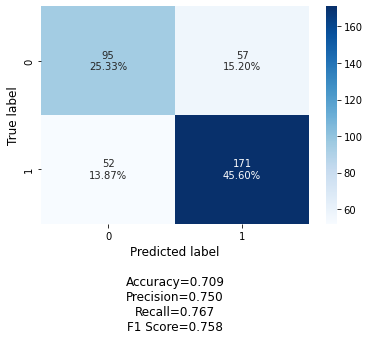

In [36]:
from utils.classification import plot_confusion_matrix

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cf_matrix)

In [37]:
# Checkout how to integrate feature selection methods inside of your Pipeline here: https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html

# Get the max number of features that model can use
processing_and_fe_steps = [
    ('preprocessor', preprocessor),
    ('interactions', PolynomialFeatures())
]
processing_and_fe_pipeline = Pipeline(processing_and_fe_steps)
n_features = processing_and_fe_pipeline.fit_transform(X_train).shape[1]

k_list = np.linspace(10, n_features, dtype="int")
test_accuracys = []
train_accuracys = []
for k in k_list:
    steps = [
        ('preprocessor', preprocessor),
        # ('interactions', PolynomialFeatures()),
        # ('dim_red', SelectKBest(score_func=f_classif, k=k)),
        ('regressor', LogisticRegression())
    ]
    pipeline = Pipeline(steps)

    # Fit the model and score it
    pipeline.fit(X_train, y_train)

    test_accuracy = pipeline.score(X_test, y_test)
    train_accuracy = pipeline.score(X_train, y_train)
    test_accuracys.append(test_accuracy)
    train_accuracys.append(train_accuracy)

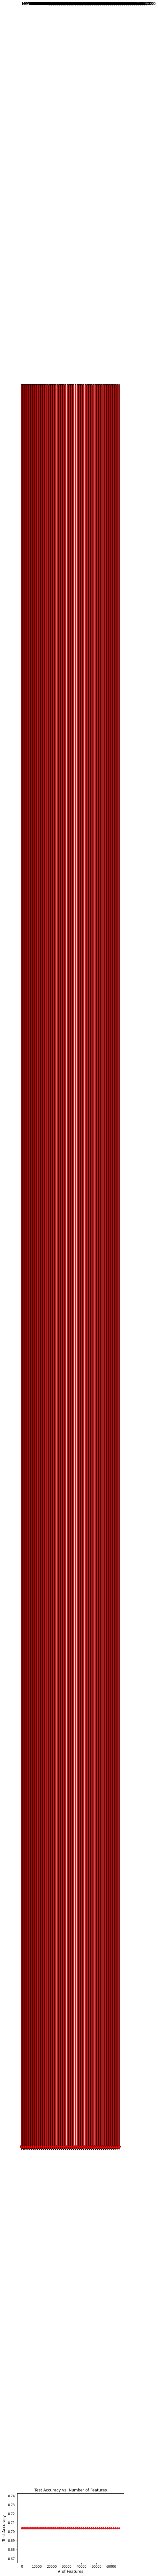

Min Test Accuracy of 0.70 acheived with 10 features
Min Test Accuracy of 0.70 acheived with 1343 features
Min Test Accuracy of 0.70 acheived with 2676 features
Min Test Accuracy of 0.70 acheived with 4009 features
Min Test Accuracy of 0.70 acheived with 5343 features
Min Test Accuracy of 0.70 acheived with 6676 features
Min Test Accuracy of 0.70 acheived with 8009 features
Min Test Accuracy of 0.70 acheived with 9343 features
Min Test Accuracy of 0.70 acheived with 10676 features
Min Test Accuracy of 0.70 acheived with 12009 features
Min Test Accuracy of 0.70 acheived with 13342 features
Min Test Accuracy of 0.70 acheived with 14676 features
Min Test Accuracy of 0.70 acheived with 16009 features
Min Test Accuracy of 0.70 acheived with 17342 features
Min Test Accuracy of 0.70 acheived with 18676 features
Min Test Accuracy of 0.70 acheived with 20009 features
Min Test Accuracy of 0.70 acheived with 21342 features
Min Test Accuracy of 0.70 acheived with 22675 features
Min Test Accuracy of

In [39]:
# Plot Accuracy for various # of features
sns.lineplot(x=k_list, y=test_accuracys)
minima = []
for i in list(zip(k_list, test_accuracys)):
    if i[1] == min(test_accuracys):
        minima.append(i)
        for annotation_pt in minima:
            plt.scatter(annotation_pt[0], annotation_pt[1], marker='o', c="red", s=25)
            annotation_text_position = [annotation_pt[0], annotation_pt[1] * 5]
            plt.annotate(f"Min Test Accuracy {annotation_pt[1]:,.2f}", annotation_pt, xytext=annotation_text_position, arrowprops={'facecolor':'red', "shrink":0.15})
plt.title(f"Test Accuracy vs. Number of Features")
plt.xlabel("# of Features")
plt.ylabel("Test Accuracy")
plt.show()
for annotation_pt in minima:
    print(f"Min Test Accuracy of {annotation_pt[1]:,.2f} acheived with {annotation_pt[0]} features")

### Conclusion


---

Comment on your findings here and provide a summary. Include your choice of model and present the results of the different models you tested.

### Appendix


---

Add any exploratory or supporting work that doesn't fit into the story of your report. Add any citations you used here as well.